In [19]:
import pandas as pd
data = pd.read_csv('/content/DEXINUS.csv')
data.head(), type(data)

(         DATE  DEXINUS
 0  2011-12-30  53.0100
 1  2012-01-02        .
 2  2012-01-03  53.1100
 3  2012-01-04  52.8500
 4  2012-01-05  52.8900,
 pandas.core.frame.DataFrame)

In [20]:
data

,DATE,DEXINUS
0,2011-12-30,53.0100
1,2012-01-02,.
2,2012-01-03,53.1100
3,2012-01-04,52.8500
4,2012-01-05,52.8900
...,...,...
3216,2024-04-29,83.46
3217,2024-04-30,83.44
3218,2024-05-01,83.45
3219,2024-05-02,83.44


In [21]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [22]:
for i in range(len(data)):
  if data['DEXINUS'][i] != '.':
    data['DEXINUS'][i] = float(data['DEXINUS'][i])
  else:
    data['DEXINUS'][i] = float(data['DEXINUS'][i-1])



In [23]:
data

,DATE,DEXINUS
0,2011-12-30,53.01
1,2012-01-02,53.01
2,2012-01-03,53.11
3,2012-01-04,52.85
4,2012-01-05,52.89
...,...,...
3216,2024-04-29,83.46
3217,2024-04-30,83.44
3218,2024-05-01,83.45
3219,2024-05-02,83.44


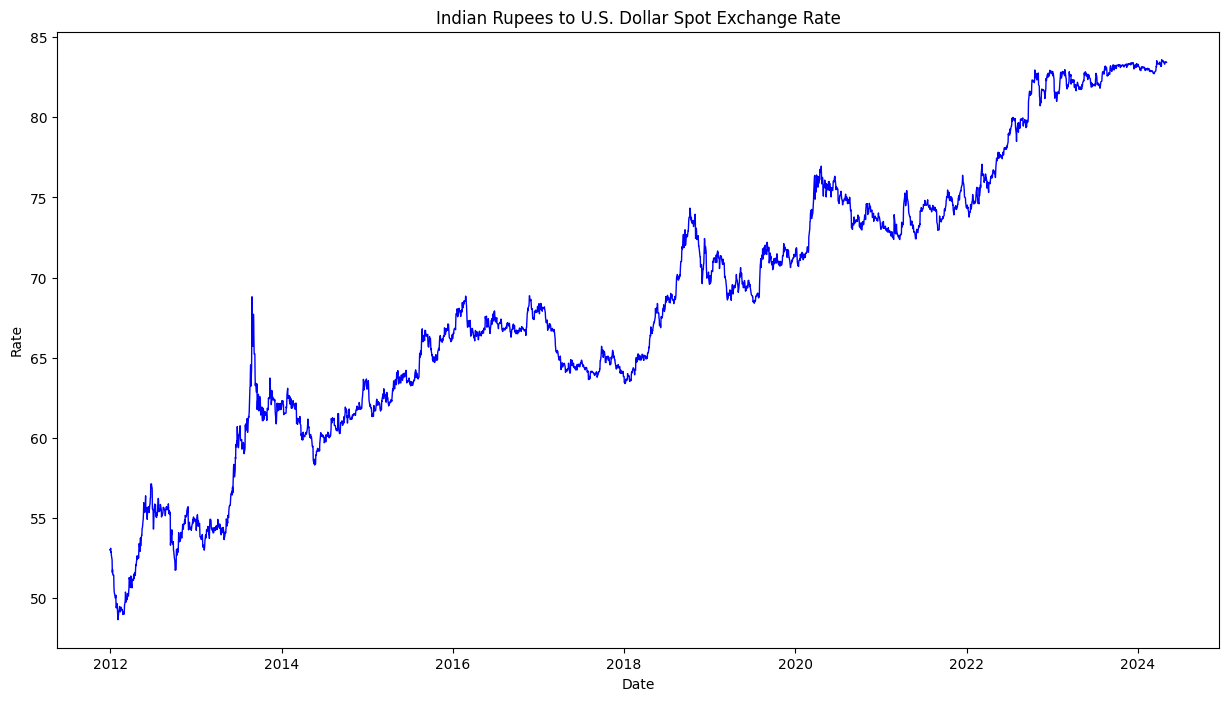

In [24]:
import matplotlib.pyplot as plt

#create pd.datetime object for plotting in the graph
dates = pd.to_datetime(data['DATE'])

# Specify the desired figure size
plt.figure(figsize=(15, 8))

# Plot the time series
plt.plot(dates, data['DEXINUS'],linestyle='-', color='blue', linewidth=1, markersize=2)

# Set plot title and labels
plt.title('Indian Rupees to U.S. Dollar Spot Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Rate')

# Show the plot
plt.show()


In [25]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3221 entries, 0 to 3220
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   DATE     3221 non-null   object
 1   DEXINUS  3221 non-null   object
dtypes: object(2)
memory usage: 50.5+ KB
None


In [26]:
data

,DATE,DEXINUS
0,2011-12-30,53.01
1,2012-01-02,53.01
2,2012-01-03,53.11
3,2012-01-04,52.85
4,2012-01-05,52.89
...,...,...
3216,2024-04-29,83.46
3217,2024-04-30,83.44
3218,2024-05-01,83.45
3219,2024-05-02,83.44


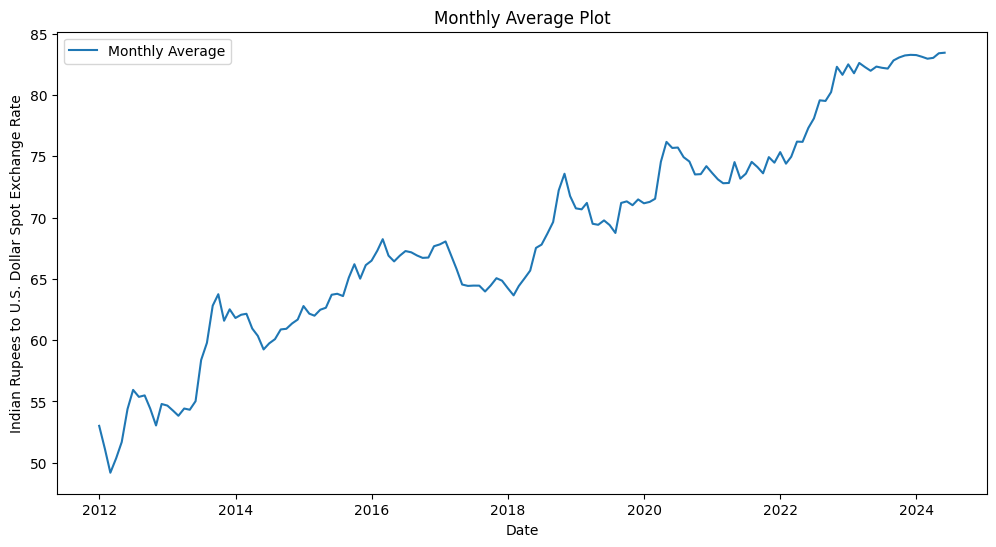

In [27]:
#Let's plot the monthy average of the time series data

import pandas as pd
import matplotlib.pyplot as plt


#let's create a copy of the dataframe
data_1 = data.copy()

# Convert 'DATE' column to datetime format
data_1['DATE'] = pd.to_datetime(data_1['DATE'])

# Set 'DATE' column as the index
data_1.set_index('DATE', inplace=True)

# Resample the data to a specific frequency (e.g., monthly) for trend analysis
monthly_data = data_1.resample('M').mean()

# Plot the resampled monthly data
plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index, monthly_data['DEXINUS'], label='Monthly Average')
plt.title('Monthly Average Plot')
plt.xlabel('Date')
plt.ylabel('Indian Rupees to U.S. Dollar Spot Exchange Rate')
plt.legend()
plt.show()


Let's Split the time series into training, validation and test sets. For this we will need pytorch's forecasting package



#REGRESSIVE LSTM NETWORK

An LSTM netowrk works by taking in some history of datapoints and mapping them to a prediction of the next datapoint. To achieve this, we need to shift our dataframe by as many time steps as we want
our model to learn from. This notebook will explore the LSTM network's ability to work out long term time series perdiction. For this two variables `max_input_length` and `max_prediction_length` will be
handle the input window size and the output prediction length

In [28]:
#review our dataset
data.head()


,DATE,DEXINUS
0,2011-12-30,53.01
1,2012-01-02,53.01
2,2012-01-03,53.11
3,2012-01-04,52.85
4,2012-01-05,52.89


In [29]:
#define the hyper-parameters
max_input_length = 60
max_prediction_length = 30

Now we will encode the year month and day values. For encoding year we will use label encoder and to encode the month and year we will use Cyclic encoder which we will build from scratch

In [30]:

class CyclicEncoder():

    """
    Cyclic Encoder class which is useful in encoding cyclic features like days and months. It uses sin and cos functions to encode the features into a two-dimensional space where cos component
    decides the horizontal component and sin component decides the vertical component.

    """
    def __init__(self):
        pass

    def fit_transform(self, original_tensor : torch.Tensor, period : int) -> torch.Tensor:
        """
        transforms the given array and returns the transformed array
        Args:
            original_tensor: the array to be transformed
            period: the period of the cyclic function
        """

        encoding = torch.zeros((2, len(original_tensor)))

        self.cos_coordinate = torch.cos((2*(torch.pi) * (original_tensor)) / period)
        self.sin_coordinate = torch.sin((2*(torch.pi) * (original_tensor)) / period)

        encoding[0, :] = self.cos_coordinate
        encoding[1, :] = self.sin_coordinate
        encoding = encoding.float()

        return encoding

    def inverse_transform(self, encoded_tensor : torch.Tensor, period : int) -> torch.Tensor:
        """
        reverts back the encoded array to the original array
        Args:
            encoded_array: the array to be reverted
            period: the period of the cyclic function
        """

        self.angles = torch.atan(encoded_tensor[:, 1]/encoded_tensor[:, 0])
        decoding = (self.angles * period) / (2 * torch.pi)
        decoding = decoding.float()

        return decoding





Now we will create a class which has all the necessary function for pre-processing data to convert our dataframe into the necessary inpur vector

In [31]:
#create a custom time series dataset of Pytorch
from torch.utils.data import Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, inputs, labels):
        super().__init__()
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]



In [32]:
from pandas import DataFrame
import sklearn
from sklearn.preprocessing import LabelEncoder
import numpy as np
from typing import Dict, List
from torch.utils.data import DataLoader
class PreProcessing():
    def __init__(self):
        pass
    #shift the columns
    def preprocess_dataframe(self, dataframe : DataFrame, window_size : int, ) -> DataFrame:
        """
        Helps create a dataframe with the necessary windows
        Args:
            data: the pandas DataFrame to be shifted
            window_size: the number of time steps to shift
        """
        df = dataframe.copy()
        dt = pd.to_datetime(df['DATE'].to_numpy())
        df['Year'] = dt.year
        df['Month'] = dt.month
        df['Day'] = dt.day
        shitfs = torch.arange(start = 1, end = window_size)
        for i in range(window_size-1):
            df[f'DEXINUS_shift_{i+1}'] = df['DEXINUS'].shift(shitfs[i])
        df.dropna(inplace=True)
        return df

    def encode_year(self, dataframe : DataFrame, transform : sklearn.preprocessing) -> torch.Tensor:
        """
        Encodes the year column
        Args:
            df: the dataframe to be encoded
        """
        df = dataframe.copy()
        g = torch.Generator().manual_seed(2184239752)
        le = transform
        year = torch.Tensor(le.fit_transform(df['Year'].to_numpy())) #(1, 3132)

        year = torch.reshape(year, (year.shape[0], 1)) # (3132, 1)
        pad = max_input_length - year.shape[1]
        year = torch.nn.functional.pad(year, (0, pad)) # (3132, 60)
        #emb = torch.randn((Year_sine.shape[1], max_input_length), generator=g)
        #year_embeddings = Year_sine @ emb # (13, 60)
        return torch.tensor(year)

    def encode_month(self, dataframe : DataFrame, transform) -> torch.Tensor:
        """
        Encodes the month column
        Args:
            df: the dataframe to be encoded
            transform: the transform to apply to the month column
        """
        df = dataframe.copy()
        g = torch.Generator().manual_seed(2184239752)
        cyc = transform
        Month = cyc.fit_transform(torch.tensor(df['Month'].to_numpy()), period=12) #2, 3132
        Month = torch.reshape(Month, (Month.shape[1], Month.shape[0]))
        pad = max_input_length - Month.shape[1]
        Month = torch.nn.functional.pad(Month, (0, pad))
        #emb = torch.randn((Month.shape[1], max_input_length), generator=g)
        #month_embeddings = Month @ emb # (12, 60)
        return Month

    def encode_day(self, dataframe : DataFrame, transform) -> torch.Tensor:
        """
        Encodes the day column
        Args:
            df: the dataframe to be encoded
            transform: the transform to apply to the day column
        """
        df = dataframe.copy()
        g = torch.Generator().manual_seed(2184239752)
        cyc = transform
        Day = cyc.fit_transform(torch.tensor(df['Day'].to_numpy()), period=31) #2, 3132
        Day = torch.reshape(Day, (Day.shape[1], Day.shape[0])) # (3132, 2)
        pad = max_input_length - Day.shape[1]
        Day = torch.nn.functional.pad(Day, (0, pad))
        #emb = torch.randn((Day.shape[1], max_input_length), generator=g)
        #day_embeddings = Day @ emb # (31, 60)
        return Day

    def train_test_split(self, dataframe : DataFrame):
        df = dataframe.copy()
        df.drop(['Year', 'Month', 'Day', 'DATE'], axis= 1, inplace=True)
        labels , inputs = [], []
        labels.append('DEXINUS')
        for i in range(max_prediction_length-1):
            labels.append(f'DEXINUS_shift_{i+1}')
        for i in range(max_input_length):
            inputs.append(f'DEXINUS_shift_{i + 30}')

        df_inputs = df.drop(columns = labels)
        df_labels = df.drop(columns = inputs)

        inputs = torch.Tensor(df_inputs.to_numpy(dtype=float))
        labels = torch.Tensor(df_labels.to_numpy(dtype=float))

        return inputs, labels

    def labeldict(self, labels : torch.Tensor, values : torch.Tensor) -> Dict[float, int]:
        return {labels[i]:values[i] for i in range(len(labels))}

    def get_dataloaders(self, inputs : torch.Tensor, labels : torch.Tensor, embeddings : List[torch.Tensor], dataset_class : TimeSeriesDataset, ratio : float = 0.8) -> DataLoader:
        features = torch.stack((inputs,
                                embeddings[0],
                                embeddings[1],
                                embeddings[2]), dim=1)


        split = int(0.8 * inputs.shape[0])
        train_inputs, train_labels = features[:split], labels[:split]
        test_inputs, test_labels = features[split:], labels[split:]
        print(train_inputs.shape), print(test_inputs.shape)
        training_data = dataset_class(train_inputs, train_labels)
        test_data = dataset_class(test_inputs, test_labels)

        train_loader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

        return train_loader, test_loader

In [33]:
pre_processing = PreProcessing()
df = pre_processing.preprocess_dataframe(dataframe = data, window_size=max_input_length + max_prediction_length)
year_labels= pre_processing.encode_year(dataframe = df, transform=LabelEncoder())
month_embeddings = pre_processing.encode_month(dataframe = df, transform=CyclicEncoder())
day_embeddings = pre_processing.encode_day(dataframe = df, transform=CyclicEncoder())
yeartolabel = pre_processing.labeldict(year_labels.unique(), torch.tensor(df['Year'].unique()))


<ipython-input-32-4e038a661a74>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(year)


In [34]:
year_labels.shape, month_embeddings.shape, day_embeddings.shape

(torch.Size([3132, 60]), torch.Size([3132, 60]), torch.Size([3132, 60]))

In [35]:

inputs, labels = pre_processing.train_test_split(df)
train_loader, test_loader = pre_processing.get_dataloaders(inputs, labels, [year_labels, month_embeddings, day_embeddings], TimeSeriesDataset)

torch.Size([2505, 4, 60])
torch.Size([627, 4, 60])


Now that the preprocessing of the dataset is completed, we will move on to creating the model for predicting the time series

In [103]:
for i in enumerate(test_loader):
  print(i)

(0, [tensor([[[74.7700, 75.0100, 74.9000,  ..., 74.5000, 74.3100, 74.1900],
         [ 9.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.5000, -0.5000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.1012, -0.2994,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[75.0000, 74.7700, 75.0100,  ..., 74.2500, 74.5000, 74.3100],
         [ 9.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.5000, -0.5000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.4853, -0.6514,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[74.8300, 75.0000, 74.7700,  ..., 74.3100, 74.2500, 74.5000],
         [ 9.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.5000, -0.5000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.9681, -0.9987,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        ...,

        [[74.2800, 74.3200, 74.3900,  ..., 74.5100, 74.6300, 74.8300],
         [10.0000,  0.0000,  0.0000,  ...,  0.0000, 

In [52]:
import torch
from torch.nn import LSTM, Linear, BatchNorm1d, Dropout
from typing import Sequence
from torch.autograd import Variable

class LSTMModel(torch.nn.Module):
    def __init__(self, input_size : int, hidden_size : int, num_layers : int, output_size : int, dropout = 0.1):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.fc_input = Linear(input_size, hidden_size)
        self.lstm = LSTM(hidden_size*4, 512, num_layers, batch_first=True)
        self.fc_output = Linear(512, output_size)
        self.bn = BatchNorm1d(hidden_size)
        self.dropout = Dropout(dropout)

    def forward(self, x: torch.Tensor):
        batch_size = x.size(0)

        # Initialize hidden state with zeros
        h_0 = Variable(torch.zeros(self.num_layers, batch_size, self.lstm.hidden_size).to(x.device))
        c_0 = Variable(torch.zeros(self.num_layers, batch_size, self.lstm.hidden_size).to(x.device))

        # Process each feature vector independently
        processed_features = []
        for i in range(x.size(1)):  # Iterate over the 4 feature vectors
            feature = x[:, i, :]  # Shape: [batch_size, sequence_length]
            feature = self.fc_input(feature)  # Shape: [batch_size, hidden_size]
            feature = self.bn(feature)  # Apply BatchNorm1d to [batch_size, hidden_size]
            feature = self.dropout(feature)  # Apply dropout
            processed_features.append(feature)

        # Stack processed features and reshape to be compatible with LSTM input
        x = torch.stack(processed_features, dim=1)  # Shape: [batch_size, num_features, hidden_size]
        x = x.view(batch_size, -1, self.hidden_size * 4)  # Combine features into the input size for LSTM

        # LSTM expects input of shape [batch_size, seq_len, input_size]
        x, _ = self.lstm(x, (h_0, c_0))

        # Pass through the output layer
        x = self.fc_output(x[:, -1, :])  # Use the last time step's output
        return x


model = LSTMModel(input_size=max_input_length, hidden_size=128, num_layers=3, output_size=max_prediction_length)
model.to(device)




LSTMModel(
  (fc_input): Linear(in_features=60, out_features=128, bias=True)
  (lstm): LSTM(512, 512, num_layers=3, batch_first=True)
  (fc_output): Linear(in_features=512, out_features=30, bias=True)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

Now that we have designed the model, we will write the training loop and testing loop

In [53]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
n_epochs = 100
loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, 'min')


In [54]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
# TensorBoard setup
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'runs/experiment_{timestamp}')
loss_train, loss_val = [], []
def train_one_epoch(epoch_index):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    loss_train.append(avg_loss)
    print(f'Epoch [{epoch_index + 1}], Training loss: {avg_loss:.4f}')
    return avg_loss

def validate():
    model.eval()
    running_vloss = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            vloss = loss_fn(outputs, labels)
            running_vloss += vloss.item()

    avg_vloss = running_vloss / len(test_loader)
    loss_val.append(avg_vloss)
    print(f'Epoch [{epoch_index + 1}], Validation loss: {avg_vloss:.4f}')
    return avg_vloss

# Training loop
EPOCHS = n_epochs
best_vloss = float('inf')

for epoch_index in range(EPOCHS):
    print(f'EPOCH {epoch_index + 1}:')

    avg_loss = train_one_epoch(epoch_index)
    avg_vloss = validate()
    scheduler.step(avg_vloss)
    writer.add_scalars('Loss', {'Training': avg_loss, 'Validation': avg_vloss}, epoch_index + 1)
    writer.flush()

    """if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = f'model_{timestamp}_epoch_{epoch_index + 1}.pth'
        torch.save(model.state_dict(), model_path)
        print(f'Model saved: {model_path}')"""

writer.close()

EPOCH 1:
Epoch [1], Training loss: 4184.4578
Epoch [1], Validation loss: 5271.6687
EPOCH 2:
Epoch [2], Training loss: 403.0661
Epoch [2], Validation loss: 81.7005
EPOCH 3:
Epoch [3], Training loss: 29.4820
Epoch [3], Validation loss: 74.0546
EPOCH 4:
Epoch [4], Training loss: 29.3761
Epoch [4], Validation loss: 72.0030
EPOCH 5:
Epoch [5], Training loss: 29.2641
Epoch [5], Validation loss: 73.7610
EPOCH 6:
Epoch [6], Training loss: 29.2078
Epoch [6], Validation loss: 71.7974
EPOCH 7:
Epoch [7], Training loss: 29.1688
Epoch [7], Validation loss: 71.8530
EPOCH 8:
Epoch [8], Training loss: 29.1136
Epoch [8], Validation loss: 69.1674
EPOCH 9:
Epoch [9], Training loss: 29.0639
Epoch [9], Validation loss: 70.4539
EPOCH 10:
Epoch [10], Training loss: 28.9985
Epoch [10], Validation loss: 68.6712
EPOCH 11:
Epoch [11], Training loss: 28.8991
Epoch [11], Validation loss: 67.5243
EPOCH 12:
Epoch [12], Training loss: 28.7928
Epoch [12], Validation loss: 68.6686
EPOCH 13:
Epoch [13], Training loss: 2

In [39]:
len(loss_train)

50

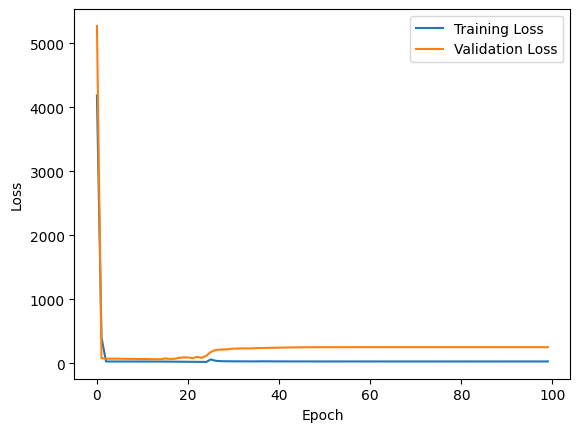

In [55]:
import matplotlib.pyplot as plt
plt.plot(loss_train, label='Training Loss')
plt.plot(loss_val, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [61]:
import torch
from torch import nn
def predict(data : torch.Tensor, model : nn.Module):
    model.eval()
    predictions = []
    for i, (inputs, labels) in enumerate(data):
        inputs = inputs.to(device)
        outputs = model(inputs)
        for i in range(outputs.shape[0]):
            predictions.append(outputs[i])
    return torch.stack(predictions)


In [68]:
predictions = predict(test_loader, model)
predictions.shape

torch.Size([627, 30])

In [96]:
train_df = data.copy()
test_df = data.copy()
train_df = train_df[:int(0.8 * len(train_df))]
test_df = test_df[int(0.8 * len(test_df)):]
predict_df['DATE'] = test_df['DATE']
predict_df["DEXINUS"] = predictions.cpu().detach().numpy().mean(1)[:625]

In [101]:
test_df.tail()

,DATE,DEXINUS
3216,2024-04-29,83.46
3217,2024-04-30,83.44
3218,2024-05-01,83.45
3219,2024-05-02,83.44
3220,2024-05-03,83.43


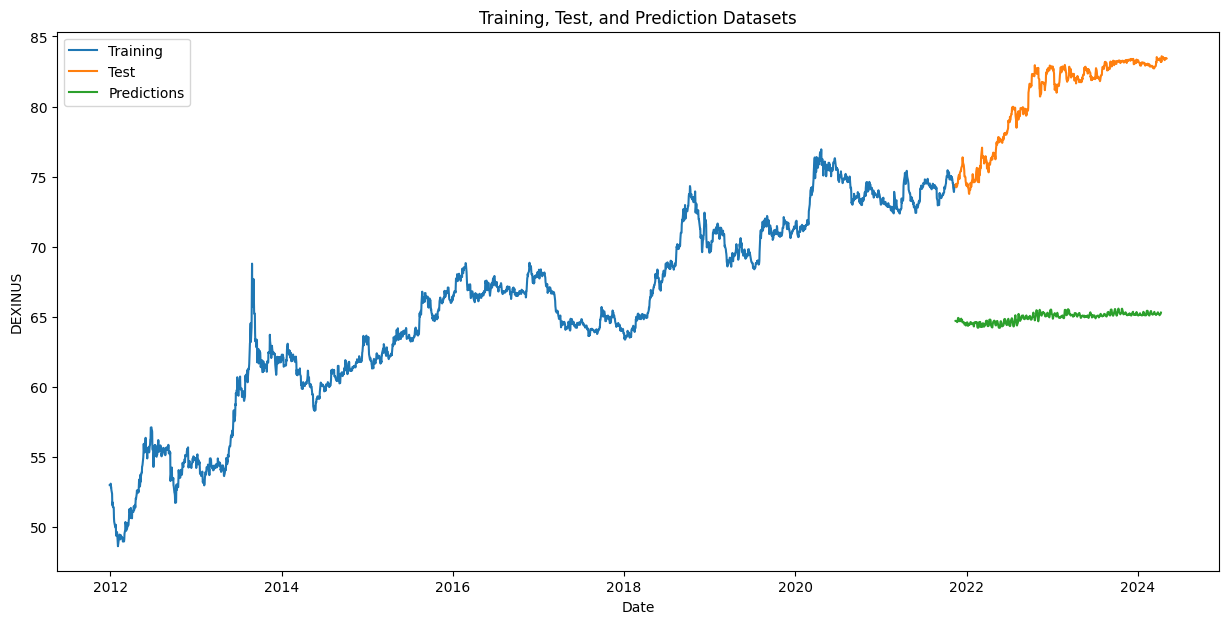

In [109]:
# Plotting the datasets
plt.figure(figsize=(15, 7))
plt.title('Training, Test, and Prediction Datasets')
plt.xlabel('Date')
plt.ylabel('DEXINUS')

plt.plot(pd.to_datetime(train_df['DATE']).to_numpy(), train_df['DEXINUS'], label='Training')
plt.plot(pd.to_datetime(test_df['DATE']).to_numpy(), test_df['DEXINUS'], label='Test')
plt.plot(pd.to_datetime(test_df['DATE']).to_numpy()[:627], predictions.cpu().detach().numpy().mean(1), label='Predictions')

plt.legend()
plt.show()


#NBEATS


In [11]:
!pip install pytorch-forecasting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3221 entries, 0 to 3220
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   DATE     3221 non-null   object
 1   DEXINUS  3221 non-null   object
dtypes: object(2)
memory usage: 50.5+ KB


In [87]:
data['DEXINUS'] = data['DEXINUS'].astype('float32')

0       53.009998
1       53.009998
2       53.110001
3       52.849998
4       52.889999
          ...    
3216    83.459999
3217    83.440002
3218    83.449997
3219    83.440002
3220    83.430000
Name: DEXINUS, Length: 3221, dtype: float32

In [88]:
import numpy as np
data['group_ids'] = np.array(['0'] * len(data))
data['time_idx'] = np.arange(len(data))
data['DEXINUS'] = data['DEXINUS'].astype('float32')


In [14]:
max_encoder_length = 7
min_encoder_length = 2
max_prediction_length = 3

In [89]:
import torch
from torch.utils.data import Dataset, Subset
import numpy as np
from torch.utils.data import DataLoader
from pytorch_forecasting.data.timeseries import TimeSeriesDataSet


class TrainTestValidationSplit(Dataset):
    def get_train_test_val_splits(self, dataframe, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):

        #calculate the length of the dataset
        length = len(dataframe)
        train_size = int(train_ratio * length)
        val_size = int(val_ratio * length)
        test_size = length - train_size - val_size

        train_dataframe = dataframe[:train_size]
        val_dataframe = dataframe[train_size:train_size+val_size]
        test_dataframe = dataframe[train_size+val_size:]

        train_dataset = TimeSeriesDataSet(train_dataframe,
                                          time_idx = 'time_idx',
                                          target=['DEXINUS'],
                                          group_ids = ['group_ids'],
                                          max_encoder_length = max_encoder_length,
                                          min_encoder_length = min_encoder_length,
                                          max_prediction_length = max_prediction_length,
                                          static_categoricals=['group_ids'],
                                          time_varying_unknown_reals=['DEXINUS'],

                                          )

        val_dataset = TimeSeriesDataSet(val_dataframe,
                                        time_idx = 'time_idx',
                                          target=['DEXINUS'],
                                          group_ids = ['group_ids'],
                                          max_encoder_length = max_encoder_length,
                                          min_encoder_length = min_encoder_length,
                                          max_prediction_length = max_prediction_length,
                                          static_categoricals=['group_ids'],
                                          time_varying_unknown_reals=['DEXINUS'],

                                          )
        test_dataset = TimeSeriesDataSet(test_dataframe,
                                         time_idx = 'time_idx',
                                          target=['DEXINUS'],
                                          group_ids = ['group_ids'],
                                          max_encoder_length = max_encoder_length,
                                          min_encoder_length = min_encoder_length,
                                          max_prediction_length = max_prediction_length,
                                          static_categoricals=['group_ids'],
                                          time_varying_unknown_reals=['DEXINUS'],

                                          )

        return train_dataset, val_dataset, test_dataset

    def get_train_test_val_dataloaders(self, train_dataset, val_dataset, test_dataset, batch_size):

        train_loader = train_dataset.to_dataloader(train = False, batch_size = batch_size, num_workers=2)
        val_loader = val_dataset.to_dataloader(train = False, batch_size = batch_size, num_workers=2)
        test_loader = test_dataset.to_dataloader(train = False, batch_size = batch_size, num_workers=2)

        return train_loader, val_loader, test_loader

In [90]:
train_dataset, val_dataset, test_dataset = TrainTestValidationSplit().get_train_test_val_splits(data, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1)
train_loader, val_loader, test_loader = TrainTestValidationSplit().get_train_test_val_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=32)

The return type of dataloader object is very import to further pass on the data to the model. The documentation for the dataloader object is [`to_dataloader` method of pytroch-forecasting](https://https://pytorch-forecasting.readthedocs.io/en/stable/api/pytorch_forecasting.data.timeseries.TimeSeriesDataSet.html#pytorch_forecasting.data.timeseries.TimeSeriesDataSet.to_dataloader)

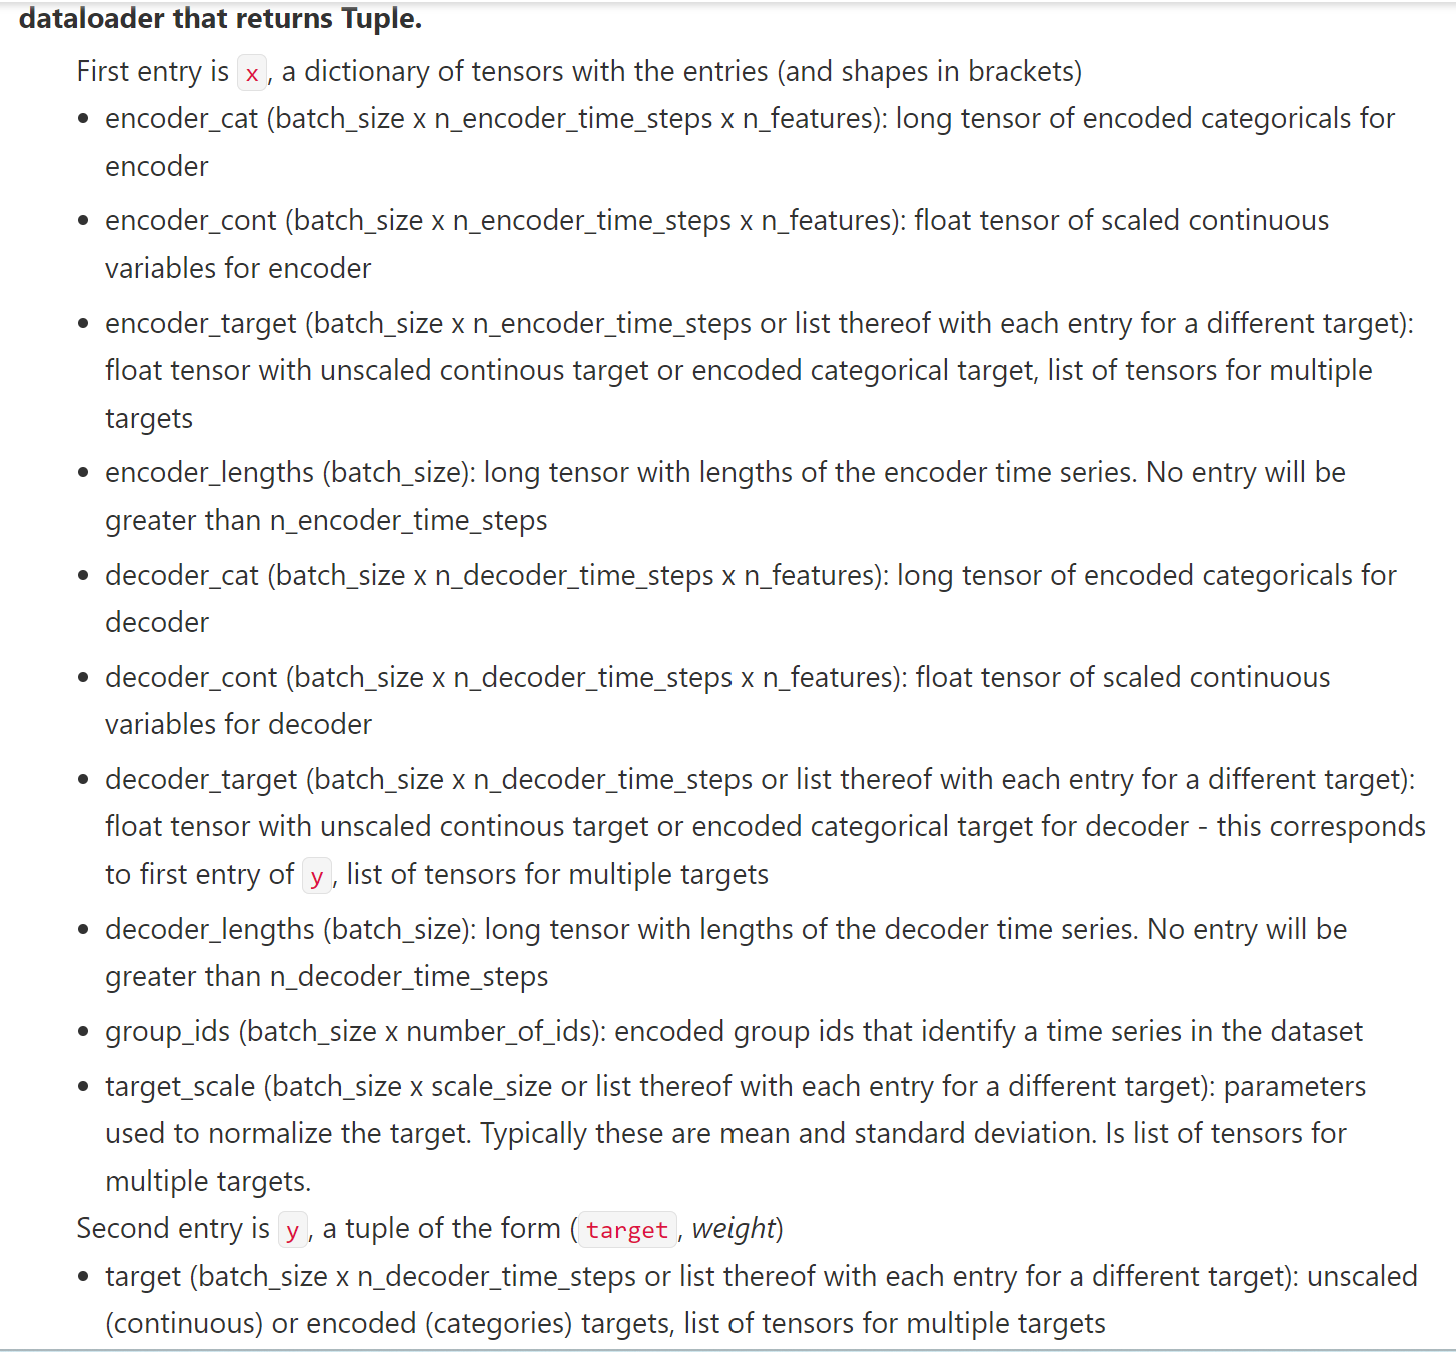

Let's visualize the training validation and test datasets on a grpah

In [18]:
length = len(data)
train_size = int(0.8 * length)
val_size = int(0.1 * length)
test_size = length - train_size - val_size

train_dataframe = data[:train_size]
val_dataframe = data[train_size:train_size+val_size]
test_dataframe = data[train_size+val_size:]
pd.to_datetime(train_dataframe['DATE']).to_numpy()

array(['2011-12-30T00:00:00.000000000', '2012-01-02T00:00:00.000000000',
       '2012-01-03T00:00:00.000000000', ...,
       '2021-11-10T00:00:00.000000000', '2021-11-11T00:00:00.000000000',
       '2021-11-12T00:00:00.000000000'], dtype='datetime64[ns]')

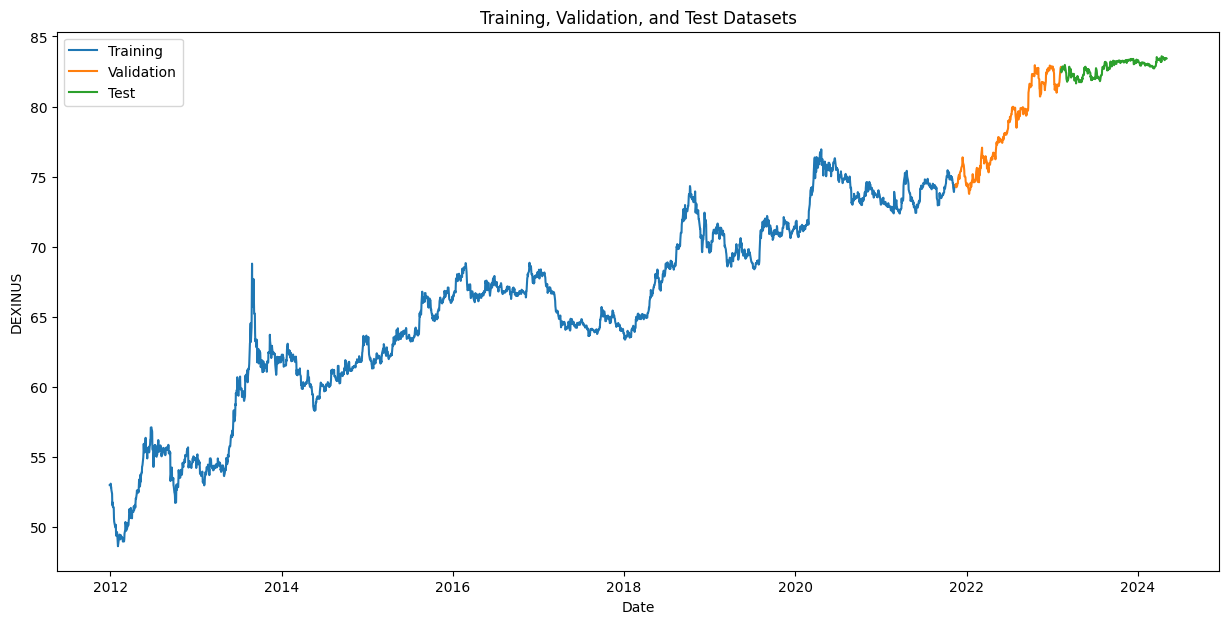

In [19]:


# Plotting the datasets
plt.figure(figsize=(15, 7))
plt.title('Training, Validation, and Test Datasets')
plt.xlabel('Date')
plt.ylabel('DEXINUS')

plt.plot(pd.to_datetime(train_dataframe['DATE']).to_numpy(), train_dataframe['DEXINUS'], label='Training')
plt.plot(pd.to_datetime(val_dataframe['DATE']).to_numpy(), val_dataframe['DEXINUS'], label='Validation')
plt.plot(pd.to_datetime(test_dataframe['DATE']).to_numpy(), test_dataframe['DEXINUS'], label='Test')

plt.legend()
plt.show()

In [97]:
print(type(torch.tensor(data['DEXINUS'], dtype=torch.float32)))

<class 'torch.Tensor'>


In [93]:
from typing import Dict, List
import torch
from pytorch_forecasting.models.rnn import RecurrentNetwork
from torch.nn import Linear
from lightning.pytorch.utilities.model_summary import ModelSummary

lstm_model = RecurrentNetwork(
    cell_type = 'LSTM',
    hidden_size = 512,
    rnn_layers = 3,
    dropout = 0.1,
    static_categoricals = ['group_ids'],
    x_reals = ['DATE'],
    target = torch.tensor(data['DEXINUS'], dtype=torch.float32),

)

print(ModelSummary(lstm_model, max_depth=-1))
print(lstm_model.hparams)


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


AssertionError: target tensor([53.0100, 53.0100, 53.1100,  ..., 83.4500, 83.4400, 83.4300]) has to be real

In [77]:
x = torch.randn(10)
print(x[..., [5, 7, 8]])
print(x)
x[..., [0]] = torch.roll(x[..., [0]], shifts=1)
print(x)

print(lstm_model.target_positions)

tensor([-1.6654, -0.5357,  0.8663])
tensor([ 0.1458, -0.5613,  0.5911,  0.3183,  1.4641, -1.6654, -0.3055, -0.5357,
         0.8663,  2.2353])
tensor([ 0.1458, -0.5613,  0.5911,  0.3183,  1.4641, -1.6654, -0.3055, -0.5357,
         0.8663,  2.2353])
tensor([0])


In [74]:
x, y = next(iter(train_loader))

print(
    "prediction shape in training:", lstm_model(x)["prediction"].size()
)  # batch_size x decoder time steps x 1 (1 for one target dimension)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (192x2 and 7x2048)

In [21]:
#Define the N-BEATS, Nhits and Autoformer Architecture
import torch.nn as nn
from pytorch_forecasting.models.nbeats import NBeats
from pytorch_forecasting.models.nhits import NHiTS
from transformers import AutoformerModel, AutoformerConfig
from pytorch_forecasting.metrics.point import MAE, MAPE, SMAPE, MASE, RMSE

In [22]:
NBEATS = NBeats(
    stack_types = ["generic", "generic", "generic"],
    num_blocks = [3, 3, 3],
    num_block_layers = [4, 4, 4],
    widths = [512, 512, 512],
    sharing = False,
    expansion_coefficient_lengths = [32, 32, 32],
    prediction_length = max_prediction_length,
    loss = MAE(),
    logging_metrics = nn.ModuleList([SMAPE(), MAE(), RMSE(), MAPE(), MASE()])
)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [23]:
NHITS = NHiTS(
    output_size = max_prediction_length,
    static_hidden_size = ['512'],
    loss = MAE(),
    logging_metrics = nn.ModuleList([SMAPE(), MAE(), RMSE(), MAPE(), MASE()]),
    downsample_frequencies = [1, 1, 1],
    pooling_sizes = [1, 1, 1]

)

In [24]:
configuration = AutoformerConfig(
    prediction_length = max_prediction_length,
    loss = 'mae',
    input_size = max_encoder_length,
)

autoformer = AutoformerModel(configuration)

In [25]:
model_dict = {
    'Lstm': lstm_model,
    'NBeats': NBEATS,
    'NHITS': NHITS,
    'Autoformer': autoformer
}

data_loaders = {
    'training': train_loader,
    'validation': val_loader,
    'testing': test_loader
}

In [26]:
#define the parameters of the model
model = model_dict['Lstm']
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.L1Loss()
n_epochs = 10
training_loader = data_loaders['training']
validation_loader = data_loaders['validation']
model_path = f'/content/Lstm.pth'

In [48]:
#creating a pytorch lightning class for training and validating the model
import lightning.pytorch as pl

class LightningModel(pl.LightningModule):
    def __init__(self, model, optimizer, loss_fn, **kwargs):
        super().__init__(**kwargs)
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn

    def forward(self, inputs, target):
        return self.model(inputs, target)

    def training_step(self, batch, batch_idx):
        inputs, target = batch
        output = self.model(inputs, target)
        loss = self.loss_fn(output, target.view(-1))

        # logs metrics for each training_step,
        # and the average across the epoch, to the progress bar and logger
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return self.optimizer

    def validation_step(self, batch, batch_idx):
        inputs, target = batch
        output = self.model(inputs, target)
        loss = self.loss_fn(output, target.view(-1))
        self.log("val_loss", loss)

    def test_step(self, batch, batch_idx):
        inputs, target = batch
        output = self.model(inputs, target)
        loss = self.loss_fn(output, target.view(-1))
        self.log("val_loss", loss)

    def predict_step(self, batch):
        inputs, target = batch
        return self.model(input)

In [49]:
lightning_model = LightningModel(model = model, optimizer = optimizer, loss_fn = loss_fn)
lightning_model.model.hparams.learning_rate

0.001

In [29]:
for i in lightning_model.model.children():
    print(i)

MultiLoss(MAE(), MAPE())
ModuleList(
  (0): MAE()
  (1): MASE()
  (2): MAPE()
  (3): SMAPE()
)
LSTM(1, 512, num_layers=3, batch_first=True, dropout=0.1)
Linear(in_features=512, out_features=1, bias=True)


In [50]:
for i, x in enumerate(val_loader):
    print(x[0]['encoder_cont'].shape)
    break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([32, 7, 2])


In [51]:
import lightning.pytorch as pl
from lightning.pytorch.tuner.tuning import Tuner

trainer = pl.Trainer(accelerator="cpu", gradient_clip_val=1e-1)
# find optimal learning rate
res = Tuner(trainer).lr_find(
    lightning_model.model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=100,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
lightning_model.model.hparams.learning_rate = res.suggestion()

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.


RuntimeError: mat1 and mat2 shapes cannot be multiplied (192x2 and 1x2048)